## Load data 

In [5]:
import pandas as pd

generic = pd.read_csv("Data/generic_mrp_results.csv")
specific = pd.read_csv("Data/specific_mrp_results.csv")
result = pd.read_csv("Data/2018_results.csv", encoding="cp1252")

In [6]:
generic = generic[generic.Demographic_Type == 'District']
specific = specific[specific.Demographic_Type == 'District']

generic = generic.dropna()
specific = specific.dropna()

In [7]:
generic.shape, specific.shape

((428, 3), (428, 3))

In [8]:
assert sum(generic.Demographic == specific.Demographic)== 428

## Preprocessing

In [9]:
# select the results only with avaiable district 

result = result[result.Dist.isin(generic.Demographic)]
result = result[['REP.', 'Dist']]
result.shape

(428, 2)

In [10]:
# pickup available results 

result = result[result['REP.'] != '—']
result = result[result['REP.'] != 'Unc.']

In [11]:
# convert text to float

result['REP.'] = result['REP.'].str.rstrip('%').astype('float')/100

result.shape

(388, 2)

In [12]:
generic = generic[generic.Demographic.isin(result.Dist)]
specific = specific[specific.Demographic.isin(result.Dist)]

In [13]:
specific = specific.sort_values(by = ['Demographic'])
generic = generic.sort_values(by = ['Demographic'])
result = result.sort_values(by = ['Dist'])
specific = specific.reset_index()
generic = generic.reset_index()
result = result.reset_index()

In [14]:
y_g = generic.Vote_R
y_s = specific.Vote_R
y_r = result['REP.']

## Model Comparison 

In [15]:
# Mean square error
import numpy as np
mse_g = np.mean((y_g - y_r)**2)
mse_s = np.mean((y_s - y_r)**2)

In [16]:
mse_g, mse_s

(0.005918537234662504, 0.0047357923785882345)

In [17]:
# accuracy, in terms of whether republican is a majority 
y_g_acc = np.where(y_g > 0.5, 1,0)
y_s_acc = np.where(y_s > 0.5, 1,0)
y_r_acc = np.where(y_r > 0.5, 1,0)

In [18]:
accuracy_g = sum(y_g_acc == y_r_acc)/len(y_g)
accuracy_s = sum(y_s_acc == y_r_acc)/len(y_g)

In [19]:
accuracy_g, accuracy_s

(0.8582474226804123, 0.8788659793814433)

In [24]:
# precision score
from sklearn.metrics import precision_score
precision_g = precision_score(y_g_acc, y_r_acc)
precision_s = precision_score(y_s_acc, y_r_acc)

precision_g, precision_s

(0.8776595744680851, 0.8723404255319149)

In [25]:
# recall score
from sklearn.metrics import recall_score
recall_g = recall_score(y_g_acc, y_r_acc)
recall_s = recall_score(y_s_acc, y_r_acc)

recall_g, recall_s

(0.8375634517766497, 0.8770053475935828)

In [26]:
# f1 score
from sklearn.metrics import f1_score
f1_g = f1_score(y_g_acc, y_r_acc)
f1_s = f1_score(y_s_acc, y_r_acc)

f1_g, f1_s

(0.8571428571428572, 0.8746666666666667)

In [84]:
Comparison = {'Model':['generic', 'specific'],
              'Accuracy':[accuracy_g, accuracy_s],
              'MSE':[mse_g, mse_s],
             'Precision':[precision_g, precision_s],
             'Recall':[recall_g, recall_s],
             'f1':[f1_g, f1_s]}

df = pd.DataFrame(Comparison)

In [86]:
df.to_csv("Model_comparison.csv")

## Calibration and callibration plot

A probabilistic model is calibrated if I binned the test samples based on their predicted probabilities, each bin’s true outcomes has a proportion close to the probabilities in the bin.

In [78]:
from sklearn.calibration import calibration_curve

general_x, general_y = calibration_curve(y_r_acc, y_g, n_bins = 10)
specific_x, specific_y = calibration_curve(y_r_acc, y_s, n_bins = 10)

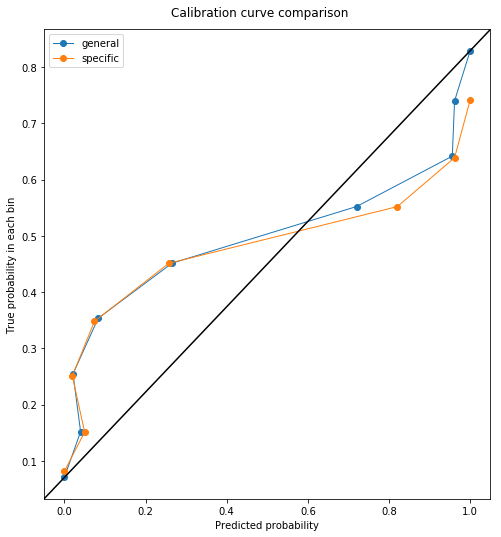

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots(figsize = (8,8))
# only these two lines are calibration curves
plt.plot(general_x, general_y, marker='o', linewidth=1, label='general')
plt.plot(specific_x, specific_y, marker='o', linewidth=1, label='specific')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration curve comparison')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
fig.subplots_adjust(top=0.94)
plt.legend()
plt.show()

In [89]:
fig.savefig("Calibration_comparison.jpg")

In [20]:
Comparison = {'Model':['generic', 'specific'],
              'Accuracy':[accuracy_g, accuracy_s],
              'MSE':[mse_g, mse_s]}

df = pd.DataFrame(Comparison)